In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import numpy as np
from mysimplepackage.simplemodule import ShowPriceValue

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import leastsq
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import datetime
from datetime import date
from scipy.stats import norm
from sklearn import preprocessing

In [2]:
df=pd.read_csv("TSLA_5Y.csv",parse_dates=["Date"],index_col=0)

df.index = pd.to_datetime(df.index, errors='coerce')
df = df.dropna()

df['Close']=df['Close'].astype(float)
#df.set_index("Date",inplace=True)

    
filter=((df.index >'2019-01-01') & (df.index<='2022-02-01'))
df=df[filter]

df['close_accum'] = (df[['Close']].pct_change()+1).cumprod()
df['close_accum']=df['close_accum'].astype(float)
df['open_pct_change']=df['Open'].pct_change()

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.reset_index()


<AxesSubplot:>

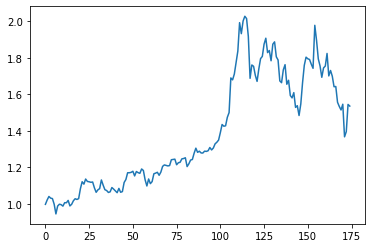

In [3]:
df['close_accum'].plot()

Predicted Price pct change


C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


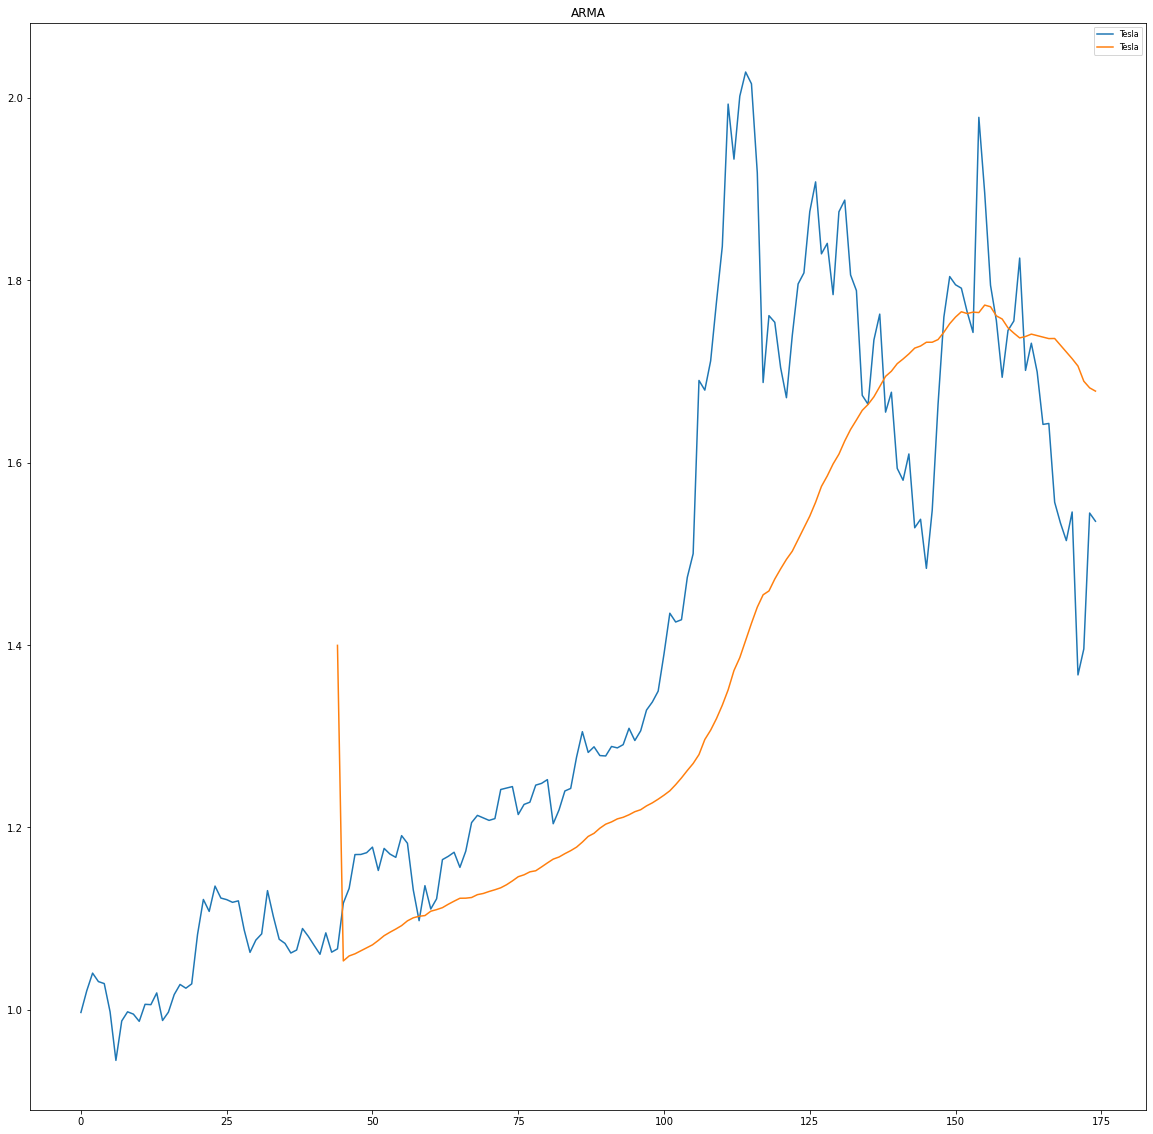

In [4]:
print("Predicted Price pct change")
def plotARMA(df_accumulative,ax,label):
    result=df_accumulative
    result=result.rolling(window=45).mean().dropna()
    mod = sm.tsa.arima.ARIMA(result, order=(2,0,0))
    res = mod.fit()
    # Plot the original series and the forecasted series
    #res.plot_predict(start=0, end=400)
    df_accumulative.plot(ax=ax,label=label)
    res.predict().plot(ax=ax,label=label)

fig,ax = plt.subplots(figsize=(20,20))    
plotARMA(df['close_accum'] ,ax,"Tesla")
plt.legend(fontsize=8)
plt.title("ARMA")
plt.show()

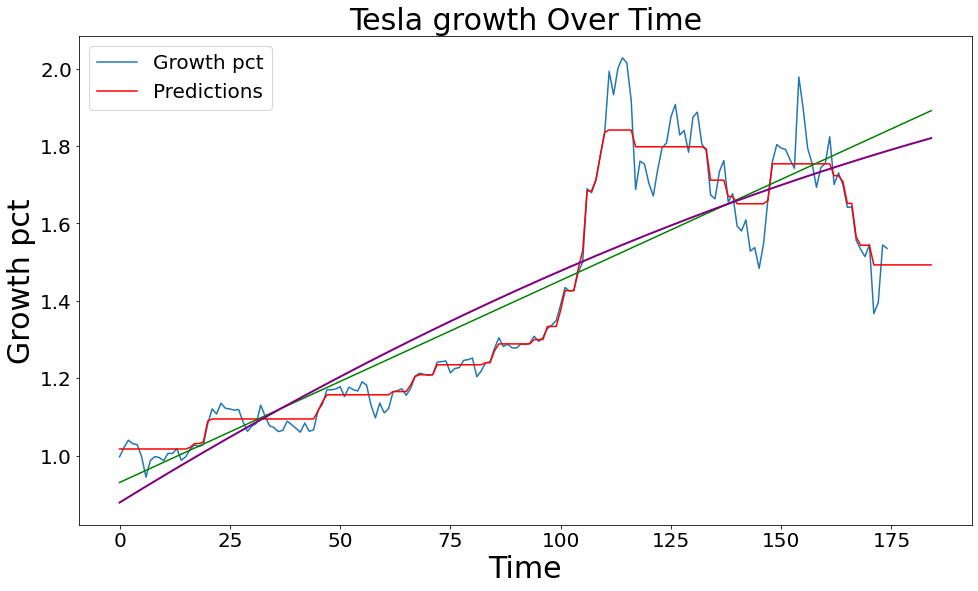

In [5]:
def func(params, x):
    a, b, c = params
    return a * x * x + b * x + c


# Error function, that is, the difference between the value obtained by fitting curve and the actual value
def error(params, x, y):
    return func(params, x) - y


def parabolicTrend(inputX,inputY):
    p0 = [10, 10, 10]
    Para = leastsq(error, p0, args=(inputX, inputY))
    return Para

days_in_future = 10
future_forecast = np.array([i for i in range(len(df)+days_in_future)]).reshape(-1, 1)
adjusted_range = future_forecast[:-10]

model = linear_model.LinearRegression()
model.fit(adjusted_range, df['close_accum'].values)


SEED=42
gbt=GradientBoostingRegressor(n_estimators=300, max_depth=1, random_state=SEED)
gbt.fit(adjusted_range, df['close_accum'])  

Para = parabolicTrend(adjusted_range.flatten(),df['close_accum'].values)
a, b, c = Para[0]
x = future_forecast
y = a * x * x + b * x + c # # function

plt.figure(figsize=(16, 9))
plt.plot(adjusted_range, df['close_accum'])
plt.plot(future_forecast,gbt.predict(future_forecast),c="red") #gbtboostingregressor
plt.plot(future_forecast,model.predict(future_forecast),c="green") #linear regressor
plt.plot(x,y,color="purple",label="solution line",linewidth=2)

plt.title('Tesla growth Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('Growth pct', size=30)
plt.legend(['Growth pct', 'Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [6]:
tesla_volatility=np.sqrt(len(df))*df['open_pct_change'].std()

print("\nvolatility rio",tesla_volatility)

print("Tesla stock is very volatile")


volatility rio 0.4635261764340323
Tesla stock is very volatile


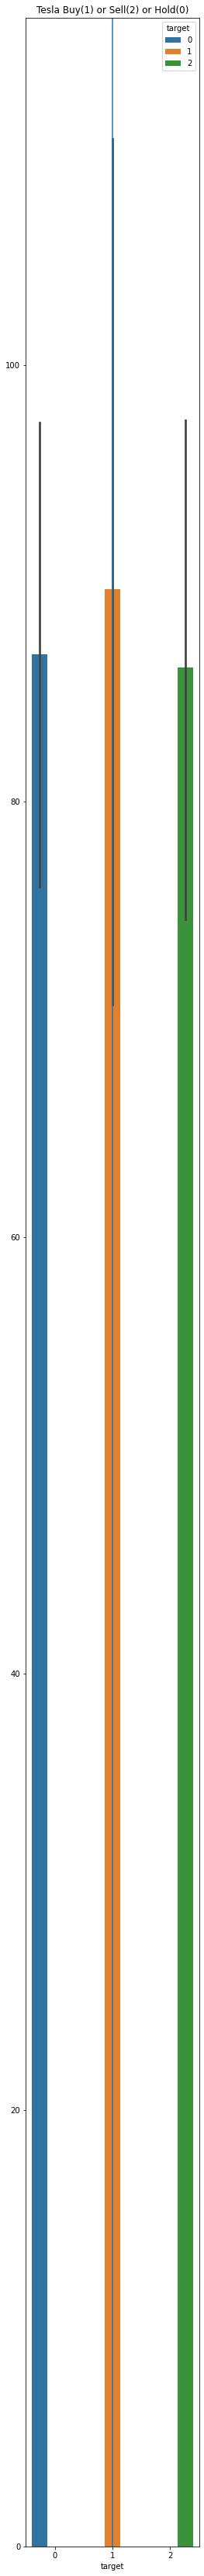

In [7]:
df["buy_count"]=0

def SetOpenPositiveCount(df):
    df["open_pct_positive_count"]=0
    for index in range(len(df)):
    #print(df.iloc[index])
        count=0
        for index2 in (range(index,0,-1)):
            #print(df.iloc[index2]["open_pct_change"])
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
                #print("found",count)
            else:
                break
        #print("count",count)
        df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    return df

def SetPctChange(df):
    for index in range(len(df)):
        count=0
        for index2 in (range(index,0,-1)):
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
            else:
                break
        df.iloc[index, df.columns.get_loc('buy_count')]=count
        
    df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
    df["target"]=0
    for index in range(len(df)):
        action=df.iloc[index]["action"]
        if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
        elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
    buy_list=df[df["target"]==1]
    #for index,item in buy_list.iterrows():
    #    print(index,item["Open"],item["open_pct_positive_count"])
    
    today = datetime.datetime.today()
    #filter=df.index.year >=  today.year-1
    #results=df[filter]
    results=df

    return results

rio_df=SetOpenPositiveCount(df)
results=SetPctChange(df)

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Tesla Buy(1) or Sell(2) or Hold(0)')
plt.show()    

Buy 42
Sell 29
Hold 17


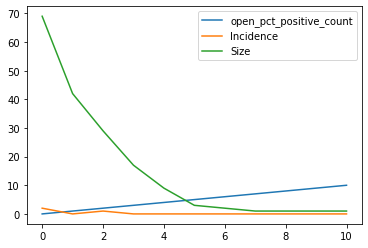

Telsa has a high frequency of buys and low hold count suggesting investors are profit taking frequently


In [8]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(rio_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(df[df['open_pct_positive_count']==1]))
print("Sell",len(df[df['open_pct_positive_count']==2]))
print("Hold",len(df[df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

print("Telsa has a high frequency of buys and low hold count suggesting investors are profit taking frequently")

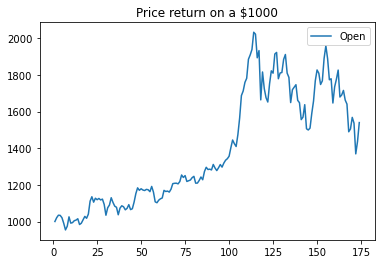

In [9]:
investment=1000

#def valuation(df,investment):
#    df_returns=df['Open'].pct_change()
#    df_returns_plus_one = df_returns.add(1)
#    df_cumulative_return = df_returns_plus_one.cumprod()
#    return df_cumulative_return.mul(investment)


lst=[(df,"Open")]
def valuation(df,investment):
    df_returns=df['Open'].pct_change()
    df_returns_plus_one = df_returns.add(1)
    df_cumulative_return = df_returns_plus_one.cumprod()
    return df_cumulative_return.mul(investment)
def ShowPriceValue(plt,lst,investment):
    for df,label in lst:
        val=valuation(df,investment)
        val.plot(label=label)
    plt.legend()
    plt.title('Price return on a $1000')
    plt.show()    
    
ShowPriceValue(plt,lst,investment)

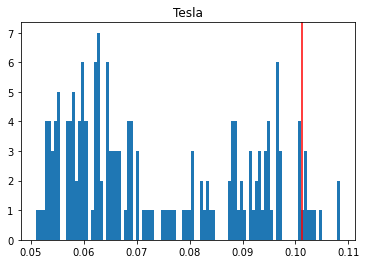

VaR 95 0.10127128450141192 VaR 99 0.10539062810228297


In [10]:
array=df['Open']
data=preprocessing.normalize([array]).flatten()
#print(data)
VaR_99 = np.quantile(data, 0.99)
VaR_95 = np.quantile(data, 0.95)

plt.hist(data, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
plt.title('Tesla')
plt.show()

print("VaR 95",VaR_95,"VaR 99",VaR_99)



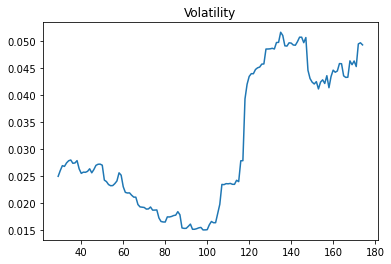

Telsa has period of fast postive and negative growth


In [11]:
rolling=df['open_pct_change'].rolling(30)
volatility=rolling.std().dropna()
volatility.plot()
plt.title("Volatility")
plt.show()


#vol_mean=volatility.resample('M').mean()
#print(vol_mean)

print("Telsa has period of fast postive and negative growth")

In [12]:
cost=df.iloc[0]['Open']*1000
print("initial cost of a 1000 shares in 2019 was an initial cost of {cost}".format(cost=cost))



initial cost of a 1000 shares in 2019 was an initial cost of 607309.9979999999
